# KERAS MODEL

## CREACION DE CENTROIDES Y UNION DE BASES DE DATOS

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':


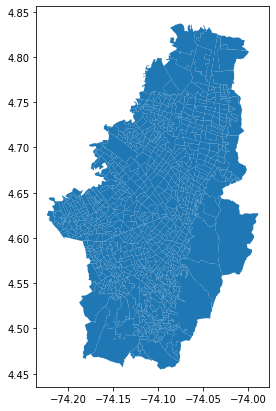

In [6]:
#hacer mapa
import pandas as pd
import geopandas as gpd
from geojson import Polygon
#from matplotlib.pyplot import figure

##se obtienen las fuentes de datos principales y se crean los centroides de cada p

barrios=gpd.read_file('scatgeojson.geojson')
#mz_values=gpd.read_file('D:\MAESTRIA\TRABAJO FINAL\BASES\MZ VALUES.geojson')
base = pd.read_excel('D:\MAESTRIA\TRABAJO FINAL\BASES\BASES DE DATOS FINALES\CONSOLIDADO AIRNBN.xlsx', sheet_name='BASE')
barrios['CENTROID']=barrios['geometry'].centroid 
barrios['LATITUDE']=barrios['CENTROID'].y
barrios['LONGITUDE']=barrios['CENTROID'].x

#barrios['SCANOMBRE']=barrios['SCANOMBRE'].astype(str)
base['Cod_Barrio']=base['Cod_Barrio'].astype(str)

datos = pd.merge(base,barrios,left_on='Barrio',right_on='SCANOMBRE')

#datos.head
#barrios.head
barrios2=barrios[barrios['LATITUDE'] >= 4.469118]  
barrios2.geometry.plot(figsize=(10, 7))

In [5]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

m = folium.Map(location=[4.6176,-74.0626], zoom_start=11)
#HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)

#for idx, row in datos.iterrows():
#    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)

#m
HeatMap(data=datos[['LATITUDE', 'LONGITUDE', 'ADR_USD (P)']].groupby(['LATITUDE', 'LONGITUDE']).mean().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m)
m

# LINEAR REGRESSION

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


datos = datos.drop(['SCACODIGO','SCANOMBRE','Shape_Length','Shape_Area','SCATIPO','Vigencia',\
                    'Observación','Cant_Propiedades (S)','Localidad','Comodidades (M)','Mascotas (M)','Cancelación (M)',\
                    'Tipo_Alqu (M)','Tipo_Aloj (M)','Fecha_Corte','Barrio','Cod_Barrio','geometry','CENTROID'], axis=1)

datos=datos[datos['Media_Arriendo'] >= 0]
datos=datos[datos['Estrato (M)'] != 'Sin Dato']
datos=datos[datos['Estrato (M)'] <= 6] 
datos['LONGITUDE']=datos['LONGITUDE']**2
datos['LATITUDE']=datos['LATITUDE']**2

datos = datos.drop(['Días_Reservados (P)','Días_Disponibles (P)','Fotos (P)','Calif_Comunicación (P)',\
                    'Calif_Valores (P)','Calif-Limpieza (P)','Calif_Localización (P)','Ingreso_USD (S)',\
                    'Ingreso_Hab_Dia (S)'], axis=1)

datos = datos.fillna(0)
for i in datos:
    datos[i]=datos[i].astype(int)
   
    
x = datos.drop(['ADR_USD (P)'], axis=1)
x = x.iloc[:,0:13]
#x = x.iloc[:,0:22]
y = datos.iloc[:,2]
#Y = tf.convert_to_tensor(Y, tf.int64)

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1)

#modelo

model = LinearRegression()
model.fit(x_train, y_train)

predict = model.predict(x)

print (y)
print ('R2 del train : '  , model.score(x_train,y_train))
print ('R2 del test : ' , model.score(x_test,y_test))
print('R2 del modelo : ', model.score(x, y))

print('Error cuadrático medio', mean_squared_error(predict, y))

0        280
1         11
2         11
3         13
4         79
        ... 
61429    309
61454     38
61455     38
61500     10
61501     10
Name: ADR_USD (P), Length: 23237, dtype: int32
R2 del train :  0.6733632225334052
R2 del test :  0.16159249651815155
R2 del modelo :  0.3583739395714254
Error cuadrático medio 3237.7857102237067


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018B82E62518>,
      dtype=object)

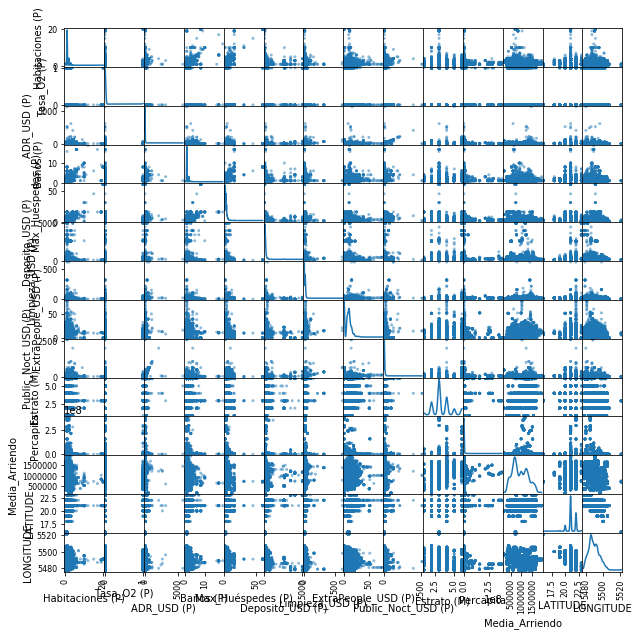

In [22]:
from pandas.plotting import scatter_matrix

scatter_matrix(datos, figsize = (10, 10), diagonal = 'kde')

## SELECCIÓN DE VARIABLES CON VARIANCE THRESHOLD

In [18]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

var_th = VarianceThreshold(threshold = 0.70)
x_var = var_th.fit_transform(x)

print("Variables originales ", x.shape[1])
print("Variables finales ", x_var.shape[1])

print("Listado de variables ", np.asarray(list(x))[var_th.get_support()])

Variables originales  13
Variables finales  10
Listado de variables  ['Habitaciones (P)' 'Max_Huéspedes (P)' 'Deposito_USD (P)'
 'Limpieza_USD (P)' 'ExtraPeople_USD (P)' 'Public_Noct_USD (P)'
 'Estrato (M)' 'Percapita' 'Media_Arriendo' 'LONGITUDE']


## MODELO LOG-POLINOMIO

In [8]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1)

#modelo

pol     = PolynomialFeatures(degree = 2, include_bias = False)
x_train = pol.fit_transform(x_train)
x_test  = pol.fit_transform(x_test)
x       = pol.fit_transform(x)
y_train = np.log(y_train)
y_test  = np.log(y_test)
y       = np.log(y)

model_2 = LinearRegression()
model_2.fit(x_train, y_train)
#model_2.fit(x_train, np.log(y_train))

predict = model_2.predict(x)

# Obtención de los parametros de ajuste

print('R^2 en train :', model_2.score(x_train, y_train))
print('R^2 en test :', model_2.score(x_test, y_test))
print('R^2', model_2.score(x, y))
print('intercepto :', model_2.intercept_)
#print('coeficientes :', model_2.coef_)

#print('R^2', model_2.score(x_train, np.log(y_train)))
#print('R^2', model_2.score(x_test, np.log(y_test)))
#print('R^2', model_2.score(x, np.log(y)))

print('Error cuadrático medio', mean_squared_error(predict, y))

R^2 en train : 0.7625817015773875
R^2 en test : 0.7114580799826615
R^2 0.7494176097525246
intercepto : 77.11826488936293
Error cuadrático medio 0.11841477188496953


# Ridge y Lasso

In [9]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso

#LASSO
#calculo del alpha para el modelo de Lasso
param_grid = dict(alpha = sp_rand())
model = Lasso()

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 1000,
                             cv = 10,
                             random_state = 1)
rsearch.fit(x, y)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

alp=rsearch.best_params_.pop("alpha")

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1212.3752808955292, tolerance: 1.0407919186954768
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1238.1129017558146, tolerance: 0.9461247260648914
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1041.517261198213, tolerance: 1.021417395250302
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1225.6831180571794, tolerance: 0.9461247260648914
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1028.4187665831687, tolerance: 1.021417395250302
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1187.7305042765129, tolerance: 1.0338219585121202
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1013.9188589719748, tolerance: 1.021417395250302
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1173.3851539826915, tolerance: 1.0338219585121202
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1147.4539886912048, tolerance: 0.9752756866842153
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1212.5920017212177, tolerance: 1.0338219585121202
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1183.6023773784473, tolerance: 0.9752756866842153
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1186.9938029991197, tolerance: 0.98363808066393
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149.7484709865796, tolerance: 0.9752756866842153
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1153.638748167748, tolerance: 0.98363808066393
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1122.419774778295, tolerance: 0.9526341875191021
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1195.5919108875066, tolerance: 0.98363808066393
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1168.838418523543, tolerance: 0.9526341875191021
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1210.0232589053776, tolerance: 0.9891734117997387
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1114.3788973816543, tolerance: 0.9526341875191021
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1157.36504789168, tolerance: 0.9891734117997387
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1151.268065762687, tolerance: 1.0019386699904635
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1233.6504426543463, tolerance: 0.9891734117997387
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1230.008971449641, tolerance: 1.0019386699904635
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1148.58730472784, tolerance: 0.9212746344819113
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1222.8133377686197, tolerance: 1.0019386699904635
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1144.043901036839, tolerance: 0.9212746344819113
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1254.8989784136018, tolerance: 1.0407919186954768
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1069.097504493355, tolerance: 0.9212746344819113
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1184.781271260702, tolerance: 1.0407919186954768
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1209.645309728911, tolerance: 0.9461247260648914
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1212.7794892751926, tolerance: 1.0407919186954768
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1238.5315585259814, tolerance: 0.9461247260648914
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1041.9655090815907, tolerance: 1.021417395250302
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1264.7277102605406, tolerance: 0.9461247260648914
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.0254441942577, tolerance: 1.021417395250302
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227.0913933283102, tolerance: 1.0338219585121202
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1083.6070899181946, tolerance: 1.021417395250302
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1239.7993867941657, tolerance: 1.0338219585121202
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208.716414788018, tolerance: 0.9752756866842153
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1252.6475481067737, tolerance: 1.0338219585121202
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1220.3356064847449, tolerance: 0.9752756866842153
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1214.05326539246, tolerance: 0.98363808066393
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205.1079543153712, tolerance: 0.9752756866842153
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1202.8672235140107, tolerance: 0.98363808066393
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1179.0140646840055, tolerance: 0.9526341875191021
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1209.7101881529175, tolerance: 0.98363808066393
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1188.5886877395099, tolerance: 0.9526341875191021
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1229.1966789987746, tolerance: 0.9891734117997387
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1112.965809937847, tolerance: 0.9526341875191021
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1155.9590020219405, tolerance: 0.9891734117997387
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149.870292607477, tolerance: 1.0019386699904635
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1166.2338571419975, tolerance: 0.9891734117997387
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1160.1743013140112, tolerance: 1.0019386699904635
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1096.325341838894, tolerance: 0.9212746344819113
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1134.0434833746358, tolerance: 1.0019386699904635
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1072.7797923686546, tolerance: 0.9212746344819113
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227.3172503813892, tolerance: 1.0407919186954768
  positive)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

KeyboardInterrupt: 

In [3]:
#modelo escogido con el alpha

model_lasso = Lasso(alpha = alp)
model_lasso.fit(x, y)

predict=model_lasso.predict(x)

print('El modelo con el nuevo alpha calculado sería ',model_lasso.coef_)
print('R2 del test :',model_lasso.score(x_test,y_test))
print('R2 del train :',model_lasso.score(x_train,y_train))
print('R2 :',model_lasso.score(x,y))

print('Error cuadrático medio', mean_squared_error(y, predict))

El modelo con el nuevo alpha calculado sería  [ 5.17872220e-01 -2.67097782e+00  5.80467505e+00  1.57404728e-01
  2.92060626e-03  1.26283814e-01 -1.52858056e-01  7.18356458e-01
  1.90389420e+00 -2.26925691e-08 -9.56307656e-07 -1.09685070e+00
 -9.09430505e-02]
R2 del test : 0.16414340261361204
R2 del train : 0.6717406650635481
R2 : 0.3593210564505336
Error cuadrático medio 3233.006350895565


In [4]:
from sklearn.linear_model import Ridge

#RIDGE
#calculo del alpha para el modelo de Ridge
param_grid = dict(alpha = sp_rand())
model = Ridge()

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 1000,
                             cv = 10,
                             random_state = 1)
rsearch.fit(x_test, y_test)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

alp=rsearch.best_params_.pop("alpha")

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71541e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45648e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4451e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31922e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30347e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26275e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74604e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31068e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41232e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30449e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32398e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42657e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31779e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70312e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44406e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44766e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43692e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31129e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29591e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2554e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40985e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30219e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72409e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46526e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45323e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29314e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2525e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73426e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30079e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40172e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31083e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27106e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75557e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31869e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4209e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46704e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45488e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32871e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31252e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27282e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33331e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3169e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27742e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76288e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32483e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75532e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31847e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42067e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31228e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70893e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31558e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41757e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30939e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70688e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44786e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40204e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29491e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71916e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46027e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44861e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26819e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75228e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31592e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41794e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30973e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27797e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7635e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32535e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42804e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31915e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72594e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46713e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45496e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32879e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31259e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30535e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73268e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47395e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46128e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33492e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31802e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2786e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76423e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32596e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42869e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30008e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73075e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47199e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45947e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33316e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26074e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74373e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30874e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41024e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30255e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45119e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32513e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30911e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26925e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75349e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73865e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30447e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40567e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29829e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70658e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75784e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32059e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42294e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3144e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72603e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44382e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43336e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30783e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29261e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25195e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31729e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71925e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46037e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4487e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32271e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46186e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45008e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32405e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30808e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26817e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7096e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45061e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43966e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31394e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29844e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31074e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29538e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25486e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73697e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30306e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44931e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32331e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30737e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26742e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7514e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44967e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43878e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31309e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29762e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25721e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70982e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45083e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43986e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31414e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29862e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72138e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46252e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45069e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32464e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30864e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32863e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31244e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27274e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75751e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32031e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29537e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71046e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45149e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44047e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31472e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31735e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27789e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76341e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32527e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42796e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42745e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31861e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73165e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4729e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46031e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42867e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31974e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73222e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47349e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46085e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32119e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30535e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26531e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74897e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31314e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2627e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74597e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31062e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41226e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30444e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44387e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43341e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30788e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29266e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.252e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40578e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2984e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71273e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45377e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44259e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76392e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3257e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42841e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3195e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72061e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26543e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74911e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31326e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41509e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30707e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46893e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45663e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33041e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31414e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27452e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32673e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31063e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27084e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75533e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31848e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30393e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73297e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47424e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46155e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33518e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45814e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33187e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31553e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27598e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76123e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32649e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3104e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27061e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75505e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31825e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30074e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26048e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74342e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30848e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40997e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2975e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25707e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73951e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3052e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40645e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45948e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33317e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31677e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27729e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76272e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30787e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72657e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46777e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45555e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32936e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29393e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25333e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73522e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30159e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40258e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31426e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27465e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7597e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32215e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42461e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74326e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30834e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40981e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30215e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73115e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71801e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45912e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44754e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32158e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30572e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76101e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32325e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42579e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31706e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71537e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44885e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32286e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30694e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26697e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75088e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29966e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71863e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45975e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44812e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32215e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33229e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31593e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2764e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76171e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32384e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32255e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42504e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31636e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72919e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47042e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26887e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75306e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31658e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41864e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31039e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45138e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44037e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31463e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29909e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25875e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31204e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41378e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30585e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72694e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46815e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46045e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44878e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32279e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30687e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2669e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30646e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26647e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7503e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31426e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41616e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31886e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42108e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31266e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72405e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46522e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46202e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33564e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31912e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27975e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76555e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30456e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26448e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74802e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31234e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4141e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43359e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30805e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29282e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25217e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73389e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4157e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30765e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71931e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46044e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44876e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45374e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3276e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31146e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27171e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75632e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44578e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43518e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3096e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2943e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25371e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45686e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44544e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31955e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30379e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26367e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30187e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40289e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29569e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70283e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44377e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72606e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46726e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45508e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3289e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3127e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4469e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32097e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30514e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26508e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74871e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45564e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32945e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31322e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27356e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75845e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29215e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25147e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73308e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29979e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40065e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32475e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42739e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31855e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73348e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47475e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3046e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71013e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45115e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44016e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31442e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31484e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29929e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25895e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74168e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30701e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30089e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71908e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4602e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44854e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32256e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31642e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27692e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7623e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32434e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42696e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41711e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30896e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72402e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4652e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45317e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29379e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72044e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46158e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44982e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3238e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3115e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4132e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30531e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71006e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45107e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27558e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76077e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32305e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42557e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31685e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44206e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31627e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30066e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26039e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74332e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31608e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70809e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44909e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43824e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31257e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70405e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.445e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43446e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30889e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29363e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3243e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30831e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26842e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75254e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31614e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29442e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7052e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44617e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43554e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30994e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32667e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42945e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32047e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70755e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44854e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4193e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.311e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72334e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46451e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45253e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30647e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71668e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45777e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44629e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32037e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30237e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7333e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47458e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46186e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33548e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3127e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27302e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75782e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32058e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42292e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75516e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31834e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42052e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31214e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72654e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2746e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75964e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3221e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42456e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3159e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76308e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.325e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42766e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3188e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72258e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76031e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32266e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42516e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31647e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72273e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32652e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31043e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27063e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75509e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31828e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33042e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31415e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27453e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75956e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32204e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30583e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40712e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29964e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70901e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45001e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43605e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31044e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2951e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25456e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73663e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25733e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73981e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30545e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40671e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29926e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31659e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71598e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45707e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44564e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31974e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74628e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31088e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41254e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30469e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70688e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42275e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31422e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72238e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46354e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45163e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27848e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76409e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32584e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42856e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31964e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3332e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31679e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27731e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76275e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32472e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29718e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70876e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44977e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43887e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31318e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4619e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33552e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31901e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27963e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76542e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31494e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41689e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30875e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70909e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45009e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70288e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44382e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43336e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30783e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29261e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32781e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31166e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27193e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75657e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31953e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76121e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32342e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42597e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31723e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72524e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45514e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44385e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31801e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30231e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26212e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31898e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42122e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31279e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70235e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44328e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7092e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45021e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43928e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31358e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29809e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40906e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30145e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70662e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4476e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43686e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30616e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71626e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45735e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4459e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31999e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45025e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43932e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31361e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29812e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25773e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3201e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3043e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26421e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74771e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31208e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74723e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31168e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41339e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30549e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73093e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2784e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76401e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32577e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42849e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31957e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31289e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71929e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46041e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44874e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32275e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4008e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29375e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73346e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47473e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46201e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7282e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46942e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45709e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33085e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31456e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30513e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26508e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74871e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31292e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41472e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71545e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45653e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44514e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31926e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30351e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29876e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73269e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47396e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46129e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33493e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2719e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75654e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3195e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42177e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31331e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32956e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31333e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27368e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75858e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32121e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25633e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73866e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30448e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40568e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2983e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30238e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73324e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47452e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46181e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33543e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44022e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31449e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29896e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2586e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74127e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32205e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42451e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31586e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71157e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4526e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33369e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31727e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2778e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76332e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32519e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70269e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44362e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43318e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30766e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29244e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31227e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29684e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25639e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73873e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30454e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75564e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31874e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42096e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31255e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71025e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30884e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26897e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75317e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31667e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41874e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33236e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31599e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27647e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76179e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32391e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73829e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30417e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40535e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29799e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71305e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71571e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45679e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44538e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31949e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30373e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30173e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72937e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4706e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45818e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33191e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31161e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29622e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25573e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73797e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3039e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33377e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31734e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27789e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76341e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32527e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44472e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43419e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30864e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29338e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25275e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31819e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42036e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31199e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71419e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45526e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45181e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32573e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30968e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26985e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75418e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72668e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46788e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45566e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32946e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31324e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73224e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4735e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46087e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33452e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31806e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40149e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29439e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72027e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4614e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44965e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45863e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33234e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31598e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27646e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76177e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44369e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31785e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30216e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26197e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74514e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30325e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26311e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74644e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31102e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41268e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31363e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41548e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30744e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73272e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47399e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31138e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29599e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2555e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7377e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30368e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43918e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31348e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.298e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2576e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74012e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70584e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44681e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43614e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31052e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29518e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42776e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31889e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70351e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44445e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43395e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30705e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71927e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46039e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44872e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32273e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41029e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3026e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71952e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46065e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44895e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30262e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26244e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74568e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31038e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.412e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40897e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30137e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7189e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46002e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44837e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\line

El mejor parametro es {'alpha': 0.9973228504514805}
El mejor score es 0.43091040285950066


C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45566e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32946e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31324e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27358e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75847e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\lin

In [5]:
#modelo escogido con el alpha
from sklearn.linear_model import Ridge

model_Ridge = Ridge(alpha = alp)
model_Ridge.fit(x_test, y_test)

pred=model_Ridge.predict(x)

print('El modelo con el nuevo alpha calculado sería ',model_Ridge.coef_)
print('R2 del test :',model_Ridge.score(x_test,y_test))
print('R2 del train :',model_Ridge.score(x_train,y_train))
print('R2 :',model_Ridge.score(x,y))

print('Error cuadrático medio', mean_squared_error(y, pred))

El modelo con el nuevo alpha calculado sería  [ 5.43981695e-01 -4.94053617e+00  5.96500448e+00  1.03365353e+00
  3.19708295e-03  1.58082407e-01 -5.72853964e-02  6.42866354e-01
  3.19525342e+00 -3.90067255e-08 -5.06447815e-07 -1.63701502e+00
 -2.18240669e-01]
R2 del test : 0.16623519395707498
R2 del train : 0.6573814917828116
R2 : 0.3550928000799527
Error cuadrático medio 3254.3430591438


C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43652e-17): result may not be accurate.
  overwrite_a=True).T


## MODELO FINAL CON KERAS

In [10]:
import geojson
import tensorflow as tf
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

barrios=gpd.read_file('scatgeojson.geojson')
#mz_values=gpd.read_file('D:\MAESTRIA\TRABAJO FINAL\BASES\MZ VALUES.geojson')
base = pd.read_excel('D:\MAESTRIA\TRABAJO FINAL\BASES\BASES DE DATOS FINALES\CONSOLIDADO AIRNBN.xlsx', sheet_name='BASE')
barrios['CENTROID']=barrios['geometry'].centroid 
barrios['LATITUDE']=barrios['CENTROID'].y
barrios['LONGITUDE']=barrios['CENTROID'].x

#barrios['SCANOMBRE']=barrios['SCANOMBRE'].astype(str)
base['Cod_Barrio']=base['Cod_Barrio'].astype(str)

datos = pd.merge(base,barrios,left_on='Barrio',right_on='SCANOMBRE')

datos = datos.drop(['SCACODIGO','SCANOMBRE','Shape_Length','Shape_Area','SCATIPO','Vigencia',\
                    'Observación','Cant_Propiedades (S)','Localidad','Comodidades (M)','Mascotas (M)','Cancelación (M)',\
                    'Tipo_Alqu (M)','Tipo_Aloj (M)','Fecha_Corte','Barrio','Cod_Barrio','geometry','CENTROID'], axis=1)

datos=datos[datos['Media_Arriendo'] >= 0]
datos=datos[datos['Estrato (M)'] != 'Sin Dato']
datos['LONGITUDE']=datos['LONGITUDE']**2
datos['LATITUDE']=datos['LATITUDE']**2

datos = datos.drop(['Días_Reservados (P)','Días_Disponibles (P)','Fotos (P)','Calif_Comunicación (P)',\
                    'Calif_Valores (P)','Calif-Limpieza (P)','Calif_Localización (P)','Ingreso_USD (S)',\
                    'Ingreso_Hab_Dia (S)'], axis=1)

datos = datos.fillna(0)
for i in datos:
    datos[i]=datos[i].astype(int)
datos=datos[datos['Estrato (M)'] <= 6]    
    
x = datos.drop(['ADR_USD (P)'], axis=1)
#x = x.iloc[:,0:22] #np.array(X)#.astype(np.float32)
x = x.iloc[:,0:13]
#X = tf.convert_to_tensor(X, np.float32)
#y = datos.iloc[:,20] #np.array(Y)#.astype(np.float32)
y = datos.iloc[:,2]
#y = np.log(y)
#Y = tf.convert_to_tensor(Y, tf.int64)

#pol     = PolynomialFeatures(degree = 3, include_bias = False)
#x       = pol.fit_transform(x)
y       = np.log(y)

def baseline_model():
    model = Sequential()
    model.add(Dense(30, input_dim=13, kernel_initializer='normal',activation='relu'))
    #model.add(Dense(7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    # compile the keras model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# fit the keras model on the dataset
#model.fit(X, Y, epochs=150, batch_size=10, verbose=0)

# evaluate the keras model
#estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
#kfold = KFold(n_splits=10)
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5)
results = cross_val_score(pipeline, x, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
print("Standardized: %.2f (%.2f) MSE" % (np.exp(results.mean()), np.exp(results.std())))

print(results)

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Standardized: -0.10 (0.02) MSE
Standardized: 0.91 (1.02) MSE
[-0.06583147 -0.09897304 -0.09720142 -0.10564242 -0.12460785]


mean error:  0.16096161705621703
min error:  2.8311669348024537e-05
max error:  5.038918988068348
std error:  0.21322002455450934


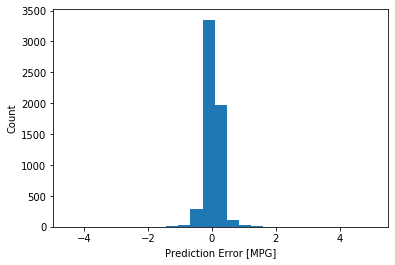

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#print("Standardized: %.2f (%.2f) MSE" % (np.exp(results.mean()), np.exp(results.std())))

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1)

pipeline.fit(x_train, y_train)
prediction = pipeline.predict(x_test)

train_error =  np.abs(y_test - prediction)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)
error = y_test - prediction

print("mean error: ", mean_error)
print("min error: ", min_error)
print("max error: ", max_error)
print("std error: ", std_error)
#train_error.plot()
#estimator.score(x, y)

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

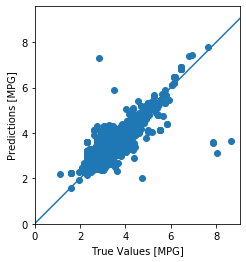

In [12]:
from tensorflow import keras

plt.scatter(y_test, prediction)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])